# Multi-network simulation test

## Simulate multiple networks with each set of parameters

### Parameters to vary:

* Number of regions
* **SNR**
    * Correlated vs. independent noise? Stick to independent for now since it's easier to generate
* IV probability
* **IV gain**
* Max eigenvalue i.e. spectral radius
    * Update - this is actually linked to the SNR, can't be controlled independently
* Heterogeneity between regions?

## Test ability of "real" vs. "pseudo" IV analysis to recover the actual connectivity strengths

### Measures of success:

* Correlation
    * Pearson vs. Spearman (rank)?
    * Compare overlap of distributions/confidence intervals?

In [1]:
%matplotlib inline
import numpy as np
from scipy import stats
import network_sim as netsim
import iv_analysis as iv
import os.path
import matplotlib.pyplot as plt
import contextlib

### Create parameter set

In [2]:
n_regions = 10
n_trials = 200
n_time = 10000

iv_prob = 0.025

gains = np.arange(0.05, 1.05, 0.05)
snrs = np.logspace(-1, 1, 9)

### Do trials for each set of parameters

In [4]:
result_file = 'iv_rs_w_seed.npz'

if not os.path.exists(result_file):
    real_iv_rs = np.ndarray((len(gains), len(snrs), n_trials))
    pseudo_iv_rs = real_iv_rs.copy()
    delayed_iv_rs = real_iv_rs.copy()
    corr_rs = real_iv_rs.copy()
    
    seeds = np.random.randint(0, 2 ** 32, dtype=np.uint32, size=(len(gains), len(snrs), n_trials))

    for i, gain in enumerate(gains):
        for j, snr in enumerate(snrs):
            for k in range(n_trials):
                
                # seed rng
                np.random.seed(seeds[i, j, k])

                # generate network and simulate
                conn_mat = netsim.gen_con_mat(n_regions)
                log_act, ivs, scaled_mat = netsim.sim_network(conn_mat, n_time, iv_prob, gain, snr)

                # do analyses
                real_betas = iv.iv_betas(log_act, ivs)
                pseudo_betas = iv.pseudo_iv_betas(log_act)
                delayed_betas = iv.delayed_iv_betas(log_act, ivs)
                corrs = np.corrcoef(log_act)

                # correlate with actual connectivity
                real_iv_rs[i, j, k], _ = stats.pearsonr(real_betas.flatten(), scaled_mat.flatten())
                pseudo_iv_rs[i, j, k], _ = stats.pearsonr(pseudo_betas.flatten(), scaled_mat.flatten())
                delayed_iv_rs[i, j, k], _ = stats.pearsonr(delayed_betas.flatten(), scaled_mat.flatten())
                corr_rs[i, j, k], _ = stats.pearsonr(corrs.flatten(), scaled_mat.flatten())


    np.savez(result_file, real=real_iv_rs, pseudo=pseudo_iv_rs, delayed=delayed_iv_rs,
             corr=corr_rs, seeds=seeds)

## Load results and plot

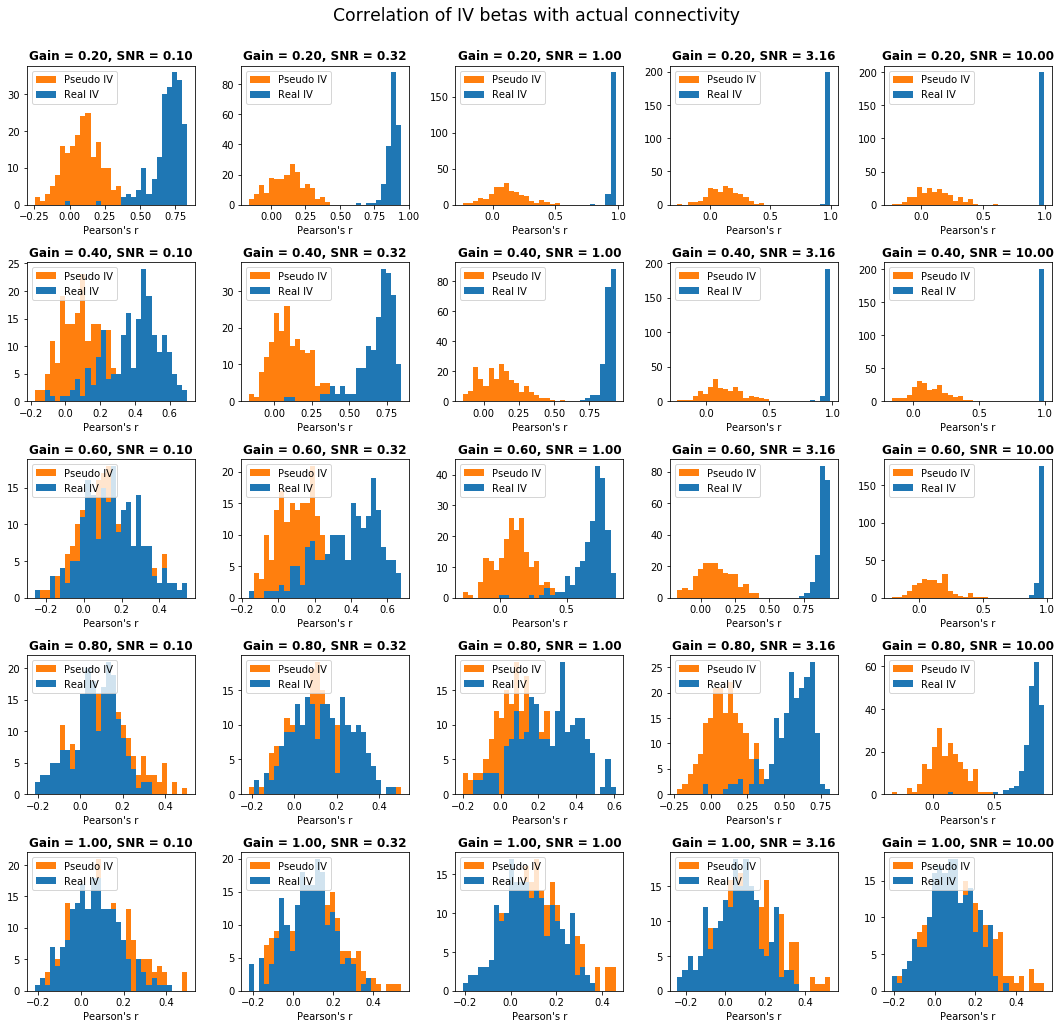

In [5]:
# example histograms, compare with gain = 0.1 and  snr = 10:

def compare_correlations(ax, gain, snr, open_file=None):
    with contextlib.nullcontext(open_file) if open_file else np.load(result_file) as iv_rs:

        ax.hist([
            iv_rs['real'][gains == gain, snrs == snr, :].flatten(),
            iv_rs['pseudo'][gains == gain, snrs == snr, :].flatten()],
            label=['Real IV', 'Pseudo IV'],
            histtype='stepfilled',
            bins=30
        )

        ax.set_xlabel('Pearson\'s r')
        ax.legend(loc='upper left')
        ax.set_title('Gain = {:.2f}, SNR = {:.2f}'.format(gain, snr), weight='bold')

gains_to_plot = gains[3::4]
snrs_to_plot = snrs[0::2]

fig, axes = plt.subplots(len(gains_to_plot), len(snrs_to_plot), figsize=(15, 15))

fig.suptitle('Correlation of IV betas with actual connectivity', size='xx-large')

with np.load(result_file) as open_file:
    for i, gain in enumerate(gains_to_plot):
        for j, snr in enumerate(snrs_to_plot):
            compare_correlations(axes[i, j], gain, snr, open_file)

fig.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.draw()

In [7]:
# example scatterplots
# generate one network of each type and plot actual connectivity vs. iv betas vs. correlations

conn_mats = np.ndarray((len(gains), len(snrs), n_regions, n_regions))
real_betas = conn_mats.copy()
real_rs = np.ndarray((len(gains), len(snrs)))
pseudo_betas = conn_mats.copy()
pseudo_rs = real_rs.copy()
corrs = conn_mats.copy()
corr_rs = real_rs.copy()

for i, gain in enumerate(gains):
    for j, snr in enumerate(snrs):
        
        # generate network and simulate
        conn_mat = netsim.gen_con_mat(n_regions)
        log_act, ivs, scaled_mat = netsim.sim_network(conn_mat, n_time, iv_prob, gain, snr)

        # do iv analyses
        real_b = iv.iv_betas(log_act, ivs)
        pseudo_b = iv.pseudo_iv_betas(log_act)
        corr = np.corrcoef(log_act)

        # correlate with actual connectivity
        real_r, _ = stats.pearsonr(real_b.flatten(), scaled_mat.flatten())
        pseudo_r, _ = stats.pearsonr(pseudo_b.flatten(), scaled_mat.flatten())
        corr_r, _ = stats.pearsonr(corr.flatten(), scaled_mat.flatten())
        
        conn_mats[i, j] = conn_mat
        real_betas[i, j] = real_b
        pseudo_betas[i, j] = pseudo_b
        corrs[i, j] = corr
        
        real_rs[i, j] = real_r
        pseudo_rs[i, j] = pseudo_r
        corr_rs[i, j] = corr_r


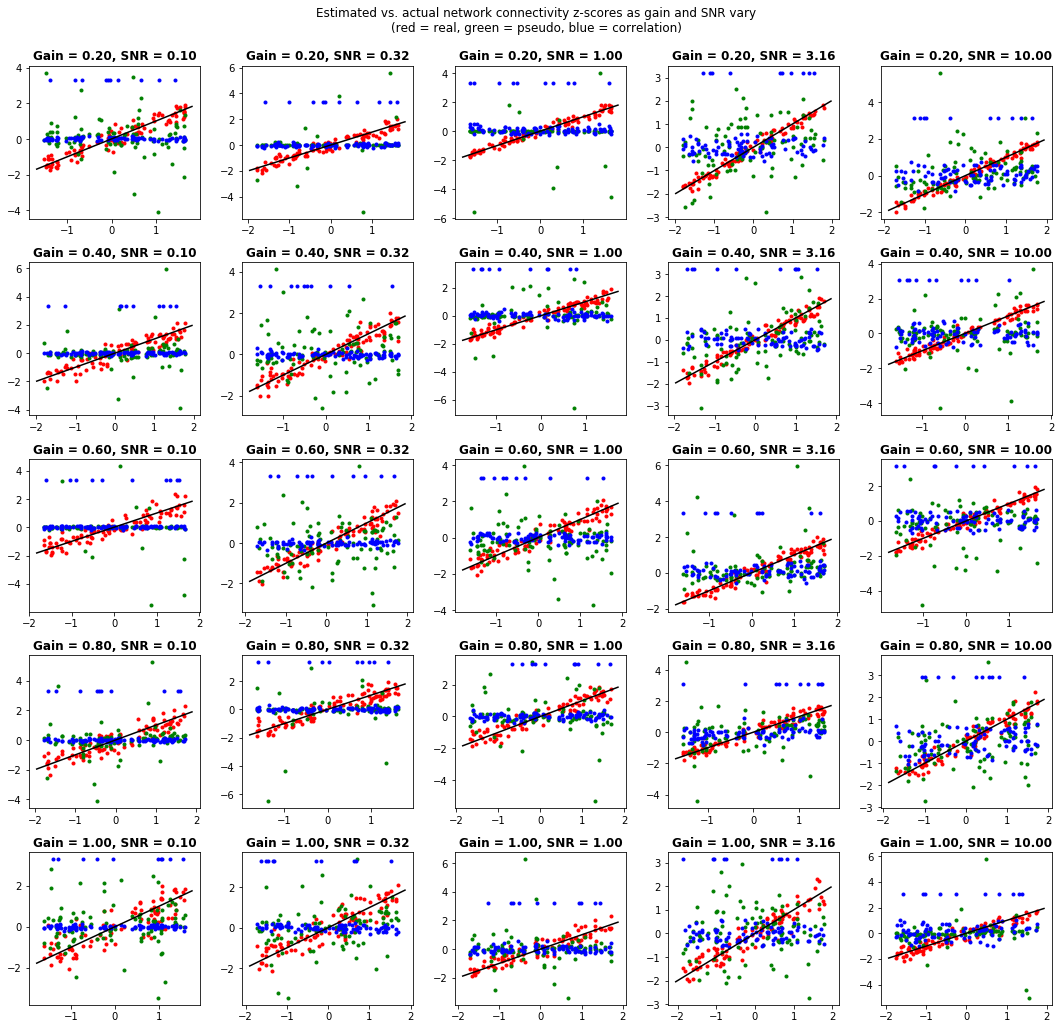

In [8]:
fig, axes = plt.subplots(len(gains_to_plot), len(snrs_to_plot), figsize=(15, 15))

fig.suptitle('Estimated vs. actual network connectivity z-scores as gain and SNR vary\n' +
            '(red = real, green = pseudo, blue = correlation)')

for i, gain in enumerate(gains_to_plot):
    for j, snr in enumerate(snrs_to_plot):
        
        ax = axes[i, j]
        
        norm_conn_mat = conn_mats[i, j] / np.std(conn_mats[i, j])
        norm_real = real_betas[i, j] / np.std(real_betas[i, j])
        norm_pseudo = pseudo_betas[i, j] / np.std(pseudo_betas[i, j])
        norm_corr = corrs[i, j] / np.std(corrs[i, j])
        
        l1 = ax.plot(norm_conn_mat.flatten(), norm_real.flatten(), 'r.')
        l2 = ax.plot(norm_conn_mat.flatten(), norm_pseudo.flatten(), 'g.')
        l3 = ax.plot(norm_conn_mat.flatten(), norm_corr.flatten(), 'b.')
        
        # identity line
        xlim = ax.get_xlim()
        ax.plot(xlim, xlim, 'k')
        
        ax.set_title('Gain = {:.2f}, SNR = {:.2f}'.format(gain, snr), weight='bold')
#         ax.legend([
#             'Real IV (r={:.2f})'.format(real_rs[i, j]),
#             'Pseudo IV (r={:.2f})'.format(pseudo_rs[i, j]),
#             'Correlation (r={:.2f})'.format(corr_rs[i, j])
#         ])

# fig.legend((l1, l2, l3), ('Real IV', 'Pseudo IV', 'Correlation'), 'upper right')
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.draw()

### Compare correctness of pseudo and real IV betas

In [9]:
def calc_dist_matrix(multidim_data, norm_ord=2):
    """
    Find the pairwise distances between multidimensional points.
    Input multidim_data should be N x D
    Distance is defined by an L2 norm by default, or specify norm_ord parameter as in np.norm
    """
    
    # rotate so variables are in 3rd dimension
    data1 = np.transpose(multidim_data[:, :, np.newaxis], (0, 2, 1))
    data2 = np.transpose(multidim_data[:, :, np.newaxis], (2, 0, 1))
    
    diff = data1 - data2  # now N x N x D
    return np.linalg.norm(diff, ord=norm_ord, axis=2)

# test on a partial cube
print(calc_dist_matrix(np.array([
    [0., 0., 0.],
    [0., 1., 0.],
    [0., 1., 1.],
    [1., 1., 1.]
])))

[[0.         1.         1.41421356 1.73205081]
 [1.         0.         1.         1.41421356]
 [1.41421356 1.         0.         1.        ]
 [1.73205081 1.41421356 1.         0.        ]]


In [10]:
def get_medoid_ind(multidim_data, norm_ord=2):
    """
    Return the index of the mediod of multidim_data, which is the point with minimal total
    distance to all other points, as defined by the norm of choice.
    """
    
    dist = calc_dist_matrix(multidim_data, norm_ord=norm_ord)
    return np.argmin(np.sum(dist, axis=0))

octo = np.array([
    [1., 0., 0.],
    [0., 1., 0.],
    [0., 0., 1.],
    [-1., 0., 0.],
    [0., -1., 0.],
    [0., 0., -1.],
    [0., 0., 0.],
])

np.set_printoptions(precision=3)
print('Dist matrix:')
print(calc_dist_matrix(octo))
print('Medoid index:', get_medoid_ind(octo))

Dist matrix:
[[0.    1.414 1.414 2.    1.414 1.414 1.   ]
 [1.414 0.    1.414 1.414 2.    1.414 1.   ]
 [1.414 1.414 0.    1.414 1.414 2.    1.   ]
 [2.    1.414 1.414 0.    1.414 1.414 1.   ]
 [1.414 2.    1.414 1.414 0.    1.414 1.   ]
 [1.414 1.414 2.    1.414 1.414 0.    1.   ]
 [1.    1.    1.    1.    1.    1.    0.   ]]
Medoid index: 6


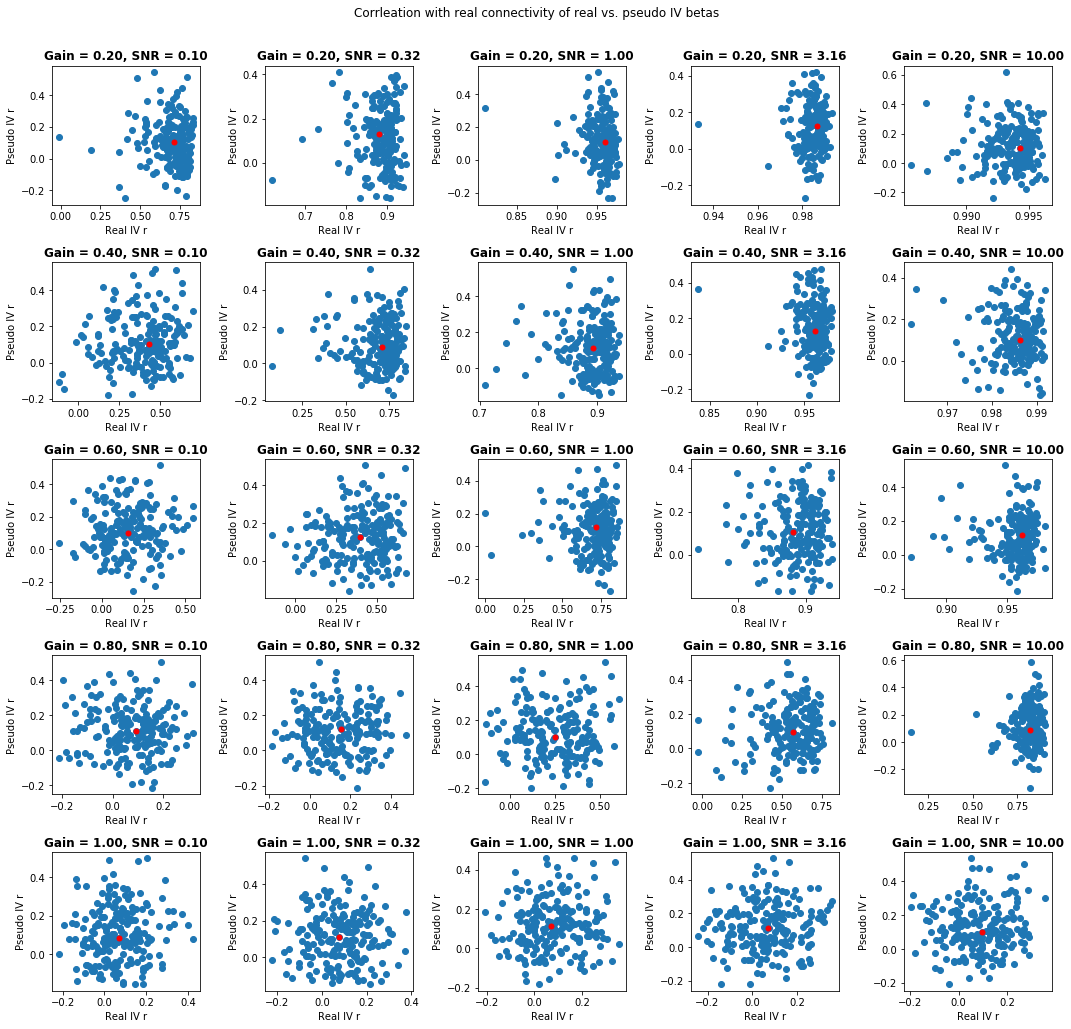

In [11]:
fig, axes = plt.subplots(len(gains_to_plot), len(snrs_to_plot), figsize=(15, 15))

fig.suptitle('Corrleation with real connectivity of real vs. pseudo IV betas')

def scatter_real_pseudo_r(ax, gain, snr, open_file=None):
    with contextlib.nullcontext(open_file) if open_file else np.load(result_file) as iv_rs:
        
        real_rs = iv_rs['real'][gains == gain, snrs == snr, :].reshape((-1, 1))
        pseudo_rs = iv_rs['pseudo'][gains == gain, snrs == snr, :].reshape((-1, 1))
        
        ax.plot(real_rs.flatten(), pseudo_rs.flatten(), 'o')
        
        medoid_ind = get_medoid_ind(np.hstack((real_rs, pseudo_rs)))
        ax.plot(real_rs[medoid_ind, 0], pseudo_rs[medoid_ind, 0], 'ro', markersize=5)
        
        ax.set_xlabel('Real IV r')
        ax.set_ylabel('Pseudo IV r')
        ax.set_title('Gain = {:.2f}, SNR = {:.2f}'.format(gain, snr), weight='bold')
        
        return medoid_ind

medoid_inds = np.ndarray((len(gains_to_plot), len(snrs_to_plot)), dtype=int)
with np.load(result_file) as open_file:
    for i, gain in enumerate(gains_to_plot):
        for j, snr in enumerate(snrs_to_plot):
            medoid_inds[i, j] = scatter_real_pseudo_r(axes[i, j], gain, snr, open_file)
            
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.draw()

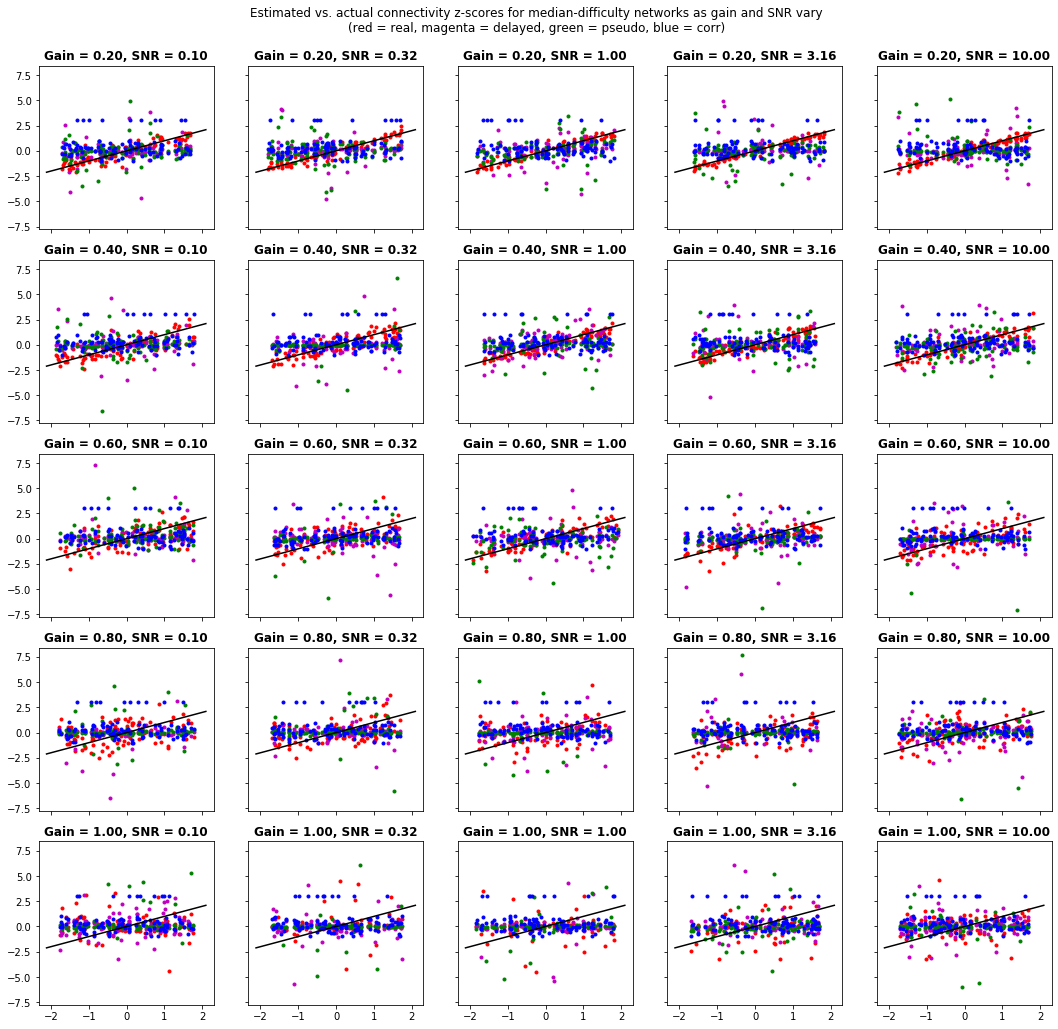

In [12]:
# re-simulate networks corresponding to medoids and make scatterplots

fig, axes = plt.subplots(len(gains_to_plot), len(snrs_to_plot), figsize=(15, 15),
                        sharex=True, sharey=True)

fig.suptitle('Estimated vs. actual connectivity z-scores for median-difficulty networks' +
             ' as gain and SNR vary\n(red = real, magenta = delayed, green = pseudo, blue = corr)')

with np.load(result_file) as iv_rs:
    for i, gain in enumerate(gains_to_plot):
        for j, snr in enumerate(snrs_to_plot):
            
            # ugh this is so ugly
            gain_ind = np.argwhere(gains == gain).flatten()[0]
            snr_ind = np.argwhere(snrs == snr).flatten()[0]
            
            # re-seed and simulate network
            seed = iv_rs['seeds'][gain_ind, snr_ind, medoid_inds[i, j]]
            np.random.seed(seed)
            
            conn_mat = netsim.gen_con_mat(n_regions)
            log_act, ivs, scaled_mat = netsim.sim_network(conn_mat, n_time, iv_prob, gain, snr)
            
            # estimate connectivity
            real_betas = iv.iv_betas(log_act, ivs)
            delayed_betas = iv.delayed_iv_betas(log_act, ivs)
            pseudo_betas = iv.pseudo_iv_betas(log_act)
            corrs = np.corrcoef(log_act)
            
            # normalize
            norm_conn_mat = conn_mat / np.std(conn_mat)
            norm_real = real_betas / np.std(real_betas)
            norm_delayed = delayed_betas / np.std(delayed_betas)
            norm_pseudo = pseudo_betas / np.std(pseudo_betas)
            norm_corrs = corrs / np.std(corrs)
            
            # plot
            axes[i, j].plot(norm_conn_mat.flatten(), norm_real.flatten(), 'r.')
            axes[i, j].plot(norm_conn_mat.flatten(), norm_delayed.flatten(), 'm.')
            axes[i, j].plot(norm_conn_mat.flatten(), norm_pseudo.flatten(), 'g.')
            axes[i, j].plot(norm_conn_mat.flatten(), norm_corr.flatten(), 'b.')
            
            axes[i, j].set_title('Gain = {:.2f}, SNR = {:.2f}'.format(gain, snr), weight='bold')
            
    # identity lines
    xlim = axes[0, 0].get_xlim()
    for ax in axes.flatten():
        ax.plot(xlim, xlim, 'k')
            
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.draw()

### For each connectivity measure (real IV, delayed IV, pseudo-IV, and correlation), plot a heatmap of the median correlation with the actual connectivity.

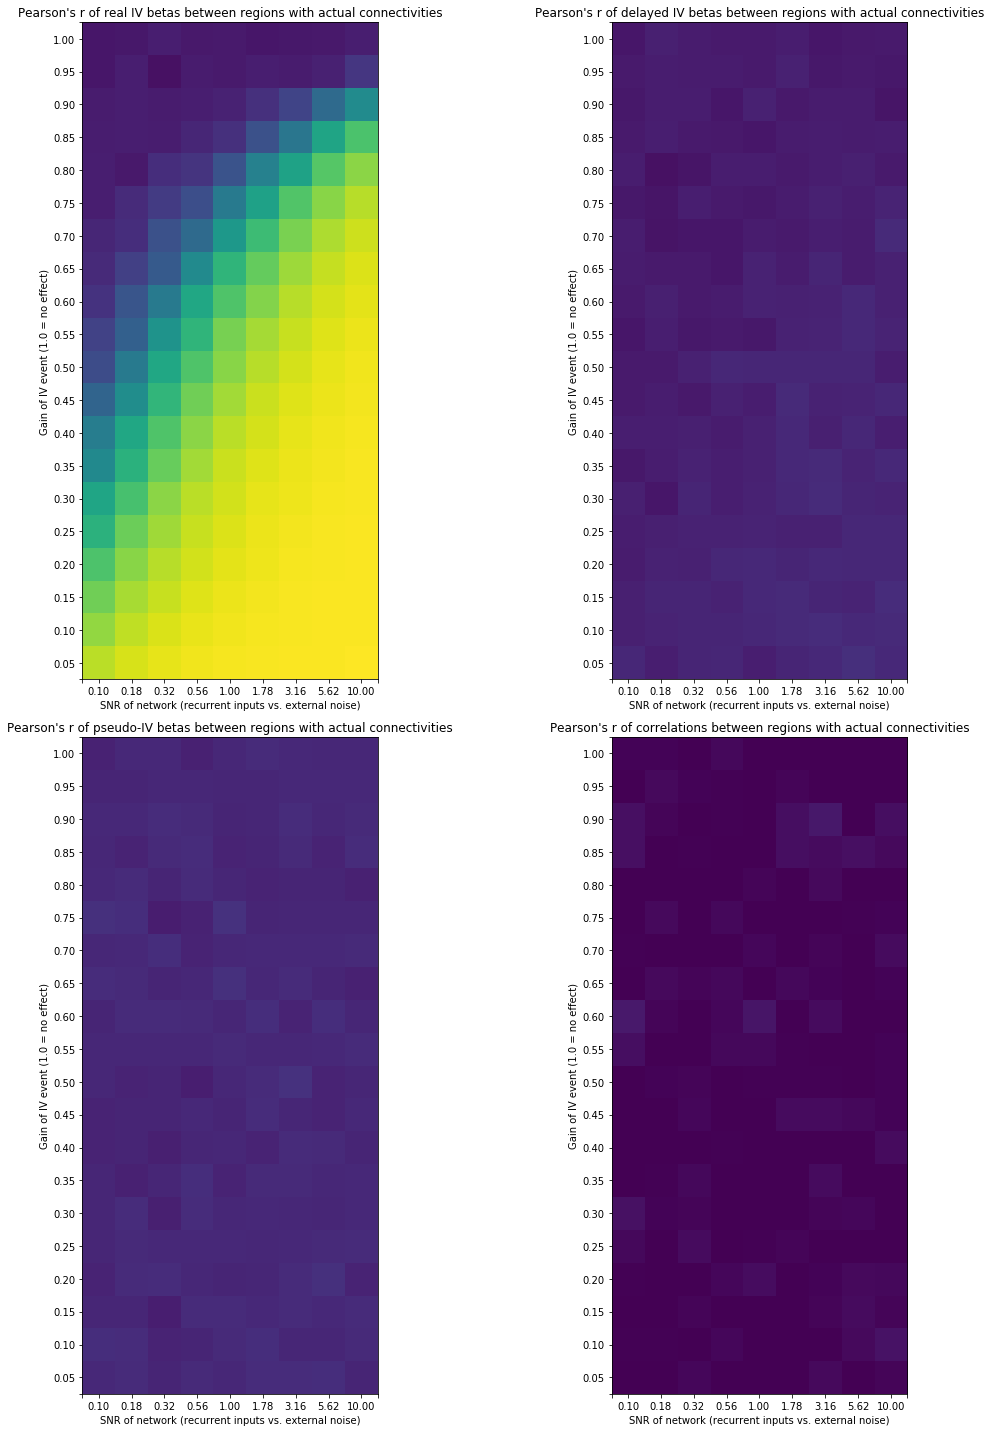

In [13]:
fig = plt.figure(figsize=(15, 20))

measures = {
    'real':    'real IV betas',
    'delayed': 'delayed IV betas',
    'pseudo':  'pseudo-IV betas',
    'corr':    'correlations'
}

with np.load(result_file) as iv_rs:
    for i, (key, name) in enumerate(measures.items()):
        ax = fig.add_subplot(2, 2, i + 1)

        med_rs = np.median(iv_rs[key], axis=2)
        ax.imshow(med_rs, origin='lower', vmin=0.0, vmax=1.0)
        
        ax.set_title('Pearson\'s r of {} between regions with actual connectivities'.format(name))
        
        # fix ticks
        ax.set_xticks([-0.5] + list(range(len(snrs))) + [len(snrs) - 0.5])
        ax.set_yticks([-0.5] + list(range(len(gains))) + [len(gains) - 0.5])
        
        ax.set_xticklabels([''] + ['{:.2f}'.format(snr) for snr in snrs])
        ax.set_yticklabels([''] + ['{:.2f}'.format(gain) for gain in gains])      
        
        ax.set_ylabel('Gain of IV event (1.0 = no effect)')
        ax.set_xlabel('SNR of network (recurrent inputs vs. external noise)')
        
fig.tight_layout()
plt.draw()